In [330]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, accuracy_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def read_atp_data(years):
    """
    Reads ATP matches data from CSV files for the specified years.

    Args:
        years (list or range): A list or range of years to read data for.

    Returns:
        pandas.DataFrame: A combined DataFrame containing all the data from the specified years.
    """
    data = []
    for year in years:
        # Check for Excel file with .xls extension
        xls_file_path = f"{year}.xls"
        if os.path.exists(xls_file_path):
            df = pd.read_excel(xls_file_path)
            data.append(df)
            continue

        # Check for Excel file with .xlsx extension
        xlsx_file_path = f"{year}.xlsx"
        if os.path.exists(xlsx_file_path):
            df = pd.read_excel(xlsx_file_path)
            data.append(df)
            continue

        # If the file is not found
        print(f"File not found: {xls_file_path}, or {xlsx_file_path}")

    if data:
        combined_data = pd.concat(data, ignore_index=True)
        return combined_data
    else:
        return None

In [331]:
def compute_point_difference(df):
    df.rename(columns={
        'Winner': 'winner_name',
        'Loser': 'loser_name',
        'WRank': 'winner_rank',
        'LRank': 'loser_rank',
        'WPts': 'winner_rank_points',
        'LPts': 'loser_rank_points',
        'Date': 'tourney_date'
    }, inplace=True)
    df["loser_rank"] = df["loser_rank"].fillna(100000)
    df["winner_rank"] = df["winner_rank"].fillna(100000)

    df["higher_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["winner_rank_points"], df["loser_rank_points"])
    df["lower_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["loser_rank_points"], df["winner_rank_points"])
    
    df["point_difference"] = df["higher_rank_points"] - df["lower_rank_points"]
    df["higher_rank_won"] = df["winner_rank"] < df["loser_rank"]
    df.dropna(inplace=True, subset=["point_difference"])
    return df

In [332]:
def accuracy(pred, actual):
    return np.mean(pred == actual)

def calibration(prob, actual):
    return np.mean(prob) / np.mean(actual)

def log_loss(prob, actual):
    return -np.mean(actual * np.log(prob) + (1 - actual) * np.log(1 - prob))

def validation_stats_calculate(df):
    acc = accuracy(df["pred"], df["actual"])
    calib = calibration(df["prob"], df["actual"])
    ll = log_loss(df["prob"], df["actual"])
    return {"accuracy": acc, "calibration": calib, "log_loss": ll}

def validation_stats(df, model_name=None):
    stats = validation_stats_calculate(df)
    print(f"{model_name}")
    print(f" - Accuracy: {stats['accuracy']:.4f}")
    print(f" - Calibration: {stats['calibration']:.4f}")
    print(f" - Log Loss: {stats['log_loss']:.4f}")
    print("--------------------------------------")
    return stats

def make_predictions(df):
    df["pred"] = df["prob"] > 0.5
    return df

In [333]:
def get_elo_prob(elo1, elo2):
    return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

In [334]:
def update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches)
    k_loser = k_func(loser_matches)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

In [335]:
def implement_elo(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_elo_before_game"] = winner_elo
        df_elo.at[index, "loser_elo_before_game"] = loser_elo

    return df_elo, elo_ratings

In [336]:
def get_bcm_probabilities(df):
    def implied_prob(row, bookie):
        alpha_w = row[f"{bookie}W"]
        beta_l = row[f"{bookie}L"]
        return beta_l / (alpha_w + beta_l)
    
    bookmakers = ["B365", "PS"]
    implied_probs_winner = []
    implied_probs_loser = []
    
    for _, row in df.iterrows():
        probs_winner = [implied_prob(row, bookie) for bookie in bookmakers]
        probs_loser = [1 - prob for prob in probs_winner]
        implied_probs_winner.append(probs_winner)
        implied_probs_loser.append(probs_loser)
    
    df["implied_prob_winner"] = np.mean(implied_probs_winner, axis=1)
    df["implied_prob_loser"] = np.mean(implied_probs_loser, axis=1)

    df["implied_prob_winner_norm"] = df["implied_prob_winner"] / (df["implied_prob_winner"] + df["implied_prob_loser"])
    df["implied_prob_loser_norm"] = df["implied_prob_loser"] / (df["implied_prob_winner"] + df["implied_prob_loser"])

    df["bcm_prob"] = df["implied_prob_winner_norm"]
    return df

In [337]:
years = range(2013, 2023)  # range of years from 2013 to 2023
df = read_atp_data(years)
df = compute_point_difference(df)
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d')
df_train = df[df["tourney_date"].dt.year < 2022].copy().reset_index(drop=True)
df_test = df[df["tourney_date"].dt.year == 2022].copy().reset_index(drop=True)

/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [338]:
# Naive Model
naive_prob = df_train["higher_rank_won"].mean()
naive_prob_arr = np.repeat(naive_prob, df_test.shape[0])
df_naive = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": naive_prob_arr})
df_naive = make_predictions(df_naive)
validation_stats(df_naive, model_name="Naive Model")

# Logistic Regression Model
X_train = df_train[["point_difference"]]
y_train = df_train["higher_rank_won"]

logistic_model = LogisticRegression(fit_intercept=False)
logistic_model.fit(X_train, y_train)

logistic_prob_arr = logistic_model.predict_proba(df_test[["point_difference"]])[:, 1]
df_logistic = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": logistic_prob_arr})
df_logistic = make_predictions(df_logistic)
validation_stats(df_logistic, model_name="Logistic Regression")

Naive Model
 - Accuracy: 0.6403
 - Calibration: 1.0149
 - Log Loss: 0.6534
--------------------------------------
Logistic Regression
 - Accuracy: 0.6403
 - Calibration: 0.9521
 - Log Loss: 0.6436
--------------------------------------


{'accuracy': 0.6403041825095057,
 'calibration': 0.9521367378668969,
 'log_loss': 0.6435733744277039}

In [339]:
def k_fixed(matches_played, k=32):
    return k
# ELO Model with fixed K-factor
df_elo_train_fixed, elo_ratings_fixed = implement_elo(df_train, k_fixed)
prob_higher_rank_fixed = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_fixed.get(winner, 1500)
    loser_elo = elo_ratings_fixed.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_fixed.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
    elo_ratings_fixed[winner] = winner_new_elo
    elo_ratings_fixed[loser] = loser_new_elo

df_k_factor_test = df_test.copy()
df_k_factor_test["prob"] = prob_higher_rank_fixed
df_k_factor_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_k_factor_test = make_predictions(df_k_factor_test)
validation_stats(df_k_factor_test, model_name="ELO Model (K-factor)")

ELO Model (K-factor)
 - Accuracy: 0.6475
 - Calibration: 0.9989
 - Log Loss: 0.6207
--------------------------------------


{'accuracy': 0.6475285171102662,
 'calibration': 0.9989253348247547,
 'log_loss': 0.6207141926449667}

In [340]:
# Define the search space for hyperparameters
space  = [
    Real(1, 50, name='k')
]

@use_named_args(space)
def objective(k):
    def k_fixed(matches_played, k=k):
        return k

    df_elo_train, elo_ratings = implement_elo(df_train, k_fixed)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameter: k=%.2f" % res_gp.x[0])

Best score=0.6490
Best parameter: k=39.79


In [341]:
def k_fixed(matches_played, k=39.79):
    return k
# ELO Model with fixed K-factor
df_elo_train_fixed, elo_ratings_fixed = implement_elo(df_train, k_fixed)
prob_higher_rank_fixed = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_fixed.get(winner, 1500)
    loser_elo = elo_ratings_fixed.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_fixed.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
    elo_ratings_fixed[winner] = winner_new_elo
    elo_ratings_fixed[loser] = loser_new_elo

df_k_factor_test = df_test.copy()
df_k_factor_test["prob"] = prob_higher_rank_fixed
df_k_factor_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_k_factor_test = make_predictions(df_k_factor_test)
validation_stats(df_k_factor_test, model_name="ELO Model (K-factor)")

ELO Model (K-factor)
 - Accuracy: 0.6490
 - Calibration: 1.0075
 - Log Loss: 0.6230
--------------------------------------


{'accuracy': 0.6490494296577947,
 'calibration': 1.0075482502088122,
 'log_loss': 0.6229596198619558}

In [342]:
def k_538(matches_played, delta=100, nu=5, sigma=0.1):
    return delta / (matches_played + nu) ** sigma
# ELO Model with k_538
df_elo_train_538, elo_ratings_538 = implement_elo(df_train, k_538)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538)")

ELO Model (k_538)
 - Accuracy: 0.6437
 - Calibration: 1.0273
 - Log Loss: 0.6316
--------------------------------------


{'accuracy': 0.6437262357414448,
 'calibration': 1.027319644671668,
 'log_loss': 0.6316249946688542}

In [343]:

# Define the search space for hyperparameters
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538(matches_played, delta=delta, nu=nu, sigma=sigma):
        return delta / (matches_played + nu) ** sigma
    
    df_elo_train, elo_ratings = implement_elo(df_train, k_538)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameters: delta=%d, nu=%d, sigma=%.2f" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Best score=0.6445
Best parameters: delta=355, nu=5, sigma=0.38


In [344]:
def k_538(matches_played, delta=355, nu=5, sigma=0.38):
    return delta / (matches_played + nu) ** sigma
# ELO Model with k_538
df_elo_train_538, elo_ratings_538 = implement_elo(df_train, k_538)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538)")

ELO Model (k_538)
 - Accuracy: 0.6441
 - Calibration: 1.0414
 - Log Loss: 0.6402
--------------------------------------


{'accuracy': 0.644106463878327,
 'calibration': 1.0413885922607116,
 'log_loss': 0.6402336351325638}

In [345]:
# Implement BCM model on test data
df_test = get_bcm_probabilities(df_test)

df_bcm = df_test.copy()
df_bcm.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_bcm["prob"] = df_bcm["bcm_prob"]
df_bcm = make_predictions(df_bcm)
validation_stats(df_bcm, model_name="Bookmakers Consensus Model (BCM)")

Bookmakers Consensus Model (BCM)
 - Accuracy: 0.7943
 - Calibration: 0.9301
 - Log Loss: 0.4900
--------------------------------------


{'accuracy': 0.7942965779467681,
 'calibration': 0.930104931592965,
 'log_loss': 0.49002812353555386}

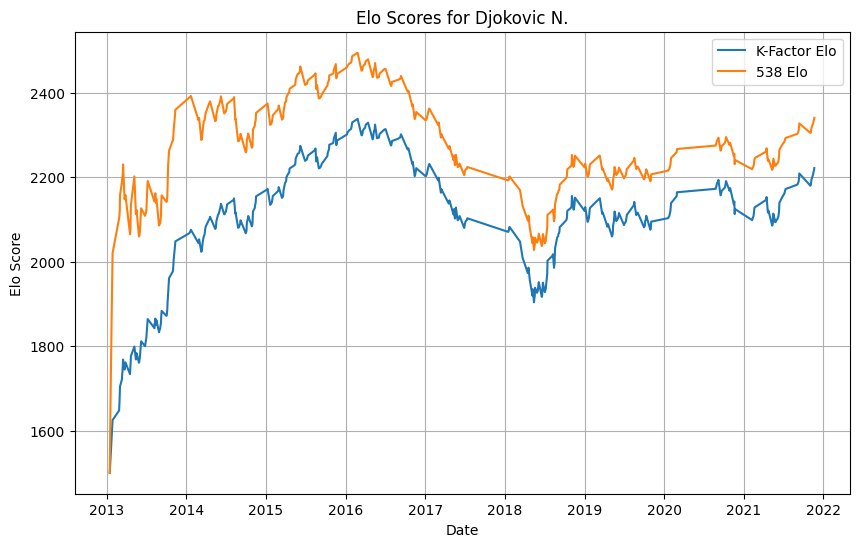

In [346]:
def get_individual_data(df, player_name):
    player_mask = (df["winner_name"] == player_name) | (df["loser_name"] == player_name)
    df_player = df[player_mask].copy()
    player_won = df_player["winner_name"] == player_name

    df_player["elo_before_game"] = np.where(player_won, df_player["winner_elo_before_game"], df_player["loser_elo_before_game"])
    df_player = df_player.sort_values("tourney_date")
    return df_player

def plot_elo_scores(player_name, df_player_k_factor, df_player_538):
    plt.figure(figsize=(10, 6))
    plt.plot(df_player_k_factor["tourney_date"], df_player_k_factor["elo_before_game"], label="K-Factor Elo")
    plt.plot(df_player_538["tourney_date"], df_player_538["elo_before_game"], label="538 Elo")
    plt.title(f"Elo Scores for {player_name}")
    plt.xlabel("Date")
    plt.ylabel("Elo Score")
    plt.legend()
    plt.grid(True)
    plt.show()

player_name = "Djokovic N."
df_player_k_factor = get_individual_data(df_elo_train_fixed, player_name)
df_player_538 = get_individual_data(df_elo_train_538, player_name)

plot_elo_scores(player_name, df_player_k_factor, df_player_538)